# This should take
- an epitope list (consisting of ID, amino acid sequence) of length _n_
- a _k_ to generate
- an inter-epitope linker (amino acid, hard code for now)
- a scaffold-epitope linker (amino acid; hard code)
- account for specified ORF?

## some math stuff
- _n_ choose _k_ without replacement
# output
- a list of epitope_IDS (i.e. ID-ID-ID), Xmas insert to be cloned into GFP -- the gBlock, basically
- the final GFP-epitope structure for each
- check that final structure does not exceed AAV payload (section between ITRs)
## bonus items
- codon optimization
- a snapgene/DNA scaffold
- restriction cloning mimc

# some biology stuff, i.e. order of events
For TBD reasons, DNAchisel doesn't work on OsX for conda istall (with no visible errors). Probably a version issue, but ?Workflow is:
1. AA: epitope combos + appropriate linkers
2. codon-optimize (mus musculus, avoid EcoRI + BsrGI sites) to DNA seq
3. Add cloning tails (known; identical) with primer length?
    primers can come from main GFP
4. Output gBlock sequences (how does Genscript want these?)


In [18]:
import itertools
import pandas as pd
from itertools import combinations
import random
from dnachisel import *
from datetime import datetime as dt
import matplotlib.pyplot as plt

from Bio import SeqIO


In [19]:
today_str = dt.now().strftime("%y%m%d") # happy autodate generator!
today_str

'220523'

In [20]:
def rSubset(arr, k):
    '''Return list of all unique subsets from an array of length  - i.e. from n choose k'''
    # return list of all subsets of length r
    # to deal with duplicate subsets use 
    # set(list(combinations(arr, r)))
    return list(combinations(arr, k))

In [21]:
def triplicator(epitope_sets, repeats=1):
    '''From a list of epitopes, generates the AA sequence with linkers in x repeat'''
    triple_set = []
    for ep in epitope_sets:
        new_ep = [(ep) for _ in range(3)]
        triple_set.append(new_ep)
    return triple_set

In [22]:
def makeTag(epitope_sets, linker=None, prepend_linker=None, append_linker=None):
    '''from a list of tuples, combine name sets + epitope sets with specified inter-epitope.
    just some string manip, basically.
    shuffles multi-epitope n choose k setups
    if a prepend is supplied, will add the specified prepend'''
    # collector of new things
    knockin = [] #the tag we're knocking in
    
    # loop the old things
    for epitope_set in epitope_sets:
        # construct name and seq into new lists
        name = []
        seq = []
        
        #shuffler to avoid bias in epitope success
        to_shuffle = list(epitope_set)
        random.shuffle(to_shuffle) 
        epitope_set = tuple(to_shuffle)
        
        # make array
        for i in range(len(epitope_set)):
            name.append(epitope_set[i][0].replace(' ',''))
            seq.append(epitope_set[i][1].strip(' '))

        # construct final name and sequence and append
        name = f'-'.join(name) # name that puppy
        seq = f'{linker}'.join(seq) #make the tag sequence
        
        if prepend_linker:
            seq = prepend_linker + seq
        if append_linker:
            seq = seq + append_linker
        knockin.append((name, seq)) #add to array

    # return new things as a dictionary
    return dict(knockin)

In [39]:
interEp = "GGT GGC AGC GGC GGT TCT".replace(" ","") #[GGS]2. for in between epitopes

# GGT GGC AGC GGC GGT TCT -- GGS GGS. need to test for hairpins.
interScaffEp = "GGT GGC AGC GGC GGT TCT".replace(" ","") #linker between eGFP end and beginning of tag

preEpitope ="ggacgagctgtacaag" #end of eGFP with BsrGI site
endEpitope = "taagaattcgatatcaag" #stop codon + EcoRI


In [40]:
interEp

'GGTGGCAGCGGCGGTTCT'

In [41]:
def read_list(csv, columns = None):
    '''returns records of name + aa seq'''
    epitopes = pd.read_csv(csv)
    records = epitopes[columns].to_records(index=False)
    return records

In [42]:
# all_list = read_list('220419_good-epitopes.csv', columns = ['Name', 'AA seq'])
# xmas_list = read_list('xmas-in-july_tagSet.csv', columns = ['Name', 'AA seq'])
# jun_list = read_list('Human Protein Atlas - under 40 AAs.csv', columns = ['Antibody','Antigen Sequence'])
xmas_list = read_list("220523_epitope-seqs.csv", columns = ['Name', 'dna_seq'])

In [43]:
xmas_sets = ['xmas',
             rSubset(xmas_list, 3)] #combo subset

In [44]:
# xmas_sets = ['xmas',
#              rSubset(xmas_list, 3)] #combo subset
# singlets = ['singlets',
#             rSubset(all_list,1)] # just easy
# triplicates = ['triplicates',
#                triplicator(all_list,3)]
# jun_triplicates = ['HPA_set',
#                    triplicator(jun_list,3)]

# tagSets = [xmas_sets, singlets, triplicates, jun_triplicates] # put these together

In [62]:
xmas_sets = ['xmas',
             rSubset(xmas_list, 3)] #combo subset
tagSets = [xmas_sets] # put these together

In [63]:
df = pd.DataFrame(xmas_sets[1])

In [64]:
columns = ['seq_name', 'seq_DNA']
df = pd.DataFrame(columns = columns)


tagType = "c-terminal"

for tagSet in tagSets:
    nameSave = tagSet[0]
    tagDict = makeTag(tagSet[1],interEp, interScaffEp) #make amino acid sequences    
    df = pd.DataFrame(tagDict.items(), columns = columns)
    df['prepend_DNA'] = preEpitope
    df['append_DNA'] = endEpitope
    df['final_synthesis'] = df['prepend_DNA'] + df['seq_DNA'] + df['append_DNA']
    df.to_excel((f'{today_str}_{nameSave}-{tagType}_choose3_DNA.xlsx'))


In [54]:
df.columns

Index(['seq_name', 'seq_DNA', 'prepend_DNA', 'append_DNA', 'final_synthesis'], dtype='object')

In [56]:
# df['len_insert'] = df.seq_aa.str.len()*3
df['len_block'] = df.final_synthesis.str.len()

7315


<AxesSubplot:>

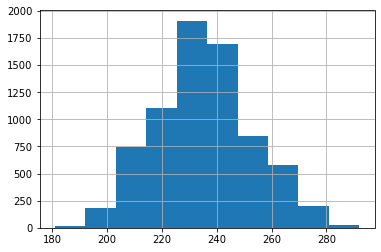

In [57]:
print(len(df))
df['len_block'].hist()

In [ ]:
records1

In [ ]:
df.columns

In [ ]:
for i in candidate_df['seq_name']:
    if i in records1:
        SeqIO.write(records1[i], output_handle1, 'fasta')
    elif i in records2:
        SeqIO.write(records2[i], output_handle1, 'fasta')

In [ ]:
df.to_excel('c-terminal-tags.xlsx')
# save the excel

# removing cut sites

This is very hacky and ugly, but taking the IDT generated codon opt and checking for BsrGI + EcoRI sites.

In [ ]:
seqs = pd.read_excel('c-terminal-tags_codonOptimized.xlsx')

In [ ]:
cloning_RE = [EnzymeSitePattern("BsrGI"), EnzymeSitePattern("EcoRI")]

cloning_RE

In [ ]:
seqs['BsrGI-site'] = seqs['IDT optimized'].str.contains(("TGTACA"))
seqs['EcoRI-site'] = seqs['IDT optimized'].str.contains(("GAATTC"))

In [ ]:
seqs.to_excel('flagged.xlsx')

In [ ]:
# problem = DnaOptimizationProblem(
#     sequence="tgtacaGGAGGCTCCGGtgtacaAGGTTCTACCGATTTTTACCTTAAGGAATTC",
#     objectives=[
#         AvoidPattern("TGTACA"), #EcoRI - hacky but oh well, can write iterator later
#         AvoidPattern(cloning_RE[1]), #BsrGI
#     ]
# )

# # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE

# problem.resolve_constraints()
# problem.optimize()

# # PRINT SUMMARIES TO CHECK THAT CONSTRAINTS PASS

# print(problem.constraints_text_summary())
# print(problem.objectives_text_summary())
# print(problem.sequence_before)
# print(problem.sequence)
# # GET THE FINAL SEQUENCE (AS STRING OR ANNOTATED BIOPYTHON RECORDS)

# final_sequence = problem.sequence  # string
# final_record = problem.to_record(with_sequence_edits=True)


In [ ]:
final_record

In [ ]:
# # 
### basically it would be nice to call things "GGS-Flagx3" rather than flag flag flag but too bad
# something breaks when _ or - are in the name
# probably needs regex but lil clean up for names

# # initializing string 
# test_str = "HPA052507-HPA052507HPA052507"
  
# # printing original string 
# print("The original string is : " + test_str)
  
# # using list slicing + find()
# # Check if string repeats itself
# res = None
# temp = (test_str + test_str).find(test_str, 1, -1)
# if temp != -1:
#     res = test_str[:temp]

# print(res)
# # print("The root substring of string : " + res)

# codon optimization o'clock
- avoid BsrGI + EcoRI
- optimize for Mus musculus
- append cloning tails

In [ ]:
test = triplet_Tags['FLAG_FLAG_FLAG']

In [ ]:
cloning_RE = [EnzymeSitePattern("BsrGI"), EnzymeSitePattern("EcoRI")]
cloning_RE

In [ ]:
def translate(seq):
    start_seq = reverse_translate(test,
                                  randomize_codons=True,
                                  table = 'Standard')

In [ ]:

problem = DnaOptimizationProblem(
    sequence=seq_test,
    constraints=[
        AvoidPattern(cloning_RE[0]), #EcoRI - hacky but oh well, can write iterator later
        AvoidPattern(cloning_RE[1]), #BsrGI
    ],
    objectives=[CodonOptimize(species='m_musculus_domesticus')]
)

# SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE

problem.resolve_constraints()
problem.optimize()

# PRINT SUMMARIES TO CHECK THAT CONSTRAINTS PASS

print(problem.constraints_text_summary())
print(problem.objectives_text_summary())

# GET THE FINAL SEQUENCE (AS STRING OR ANNOTATED BIOPYTHON RECORDS)

final_sequence = problem.sequence  # string
final_record = problem.to_record(with_sequence_edits=True)


In [ ]:
print(final_sequence)